In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_train3.h5
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_train_2_id2file.json
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/test_files.txt
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_train4.h5
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/train_files.txt
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_train1.h5
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_train_3_id2file.json
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_test_0_id2file.json
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_test1.h5
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_test0.h5
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_test_1_id2file.json
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_train_0_id2file.json
/kaggle/input/modelnet40-ply/modelnet40_ply_hdf5_2048/ply_data_train_4_id2file.j

In [2]:
!nvidia-smi

Fri Mar 31 06:08:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install plyfile

In [4]:
from __future__ import print_function
import os
import sys
import glob
import h5py
import numpy as np
import torch
import json
import cv2
import pickle
from torch.utils.data import Dataset
from plyfile import (PlyData, PlyElement, make2d, PlyParseError, PlyProperty)
import copy
import random
from torch import nn
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.batchnorm import _BatchNorm
import torch.nn.init as initer
import torch.nn.functional as F
import argparse
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data import DataLoader
import sklearn.metrics as metrics

# **以下为data_prep_util.py**

In [5]:

BASE_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(BASE_DIR)
print(BASE_DIR)

SAMPLING_BIN = os.path.join(BASE_DIR, 'pcsample')
print(SAMPLING_BIN)
SAMPLING_POINT_NUM = 2048
SAMPLING_LEAF_SIZE = 0.005

MODELNET40_PATH = '/kaggle/input/modelnet40-ply'


def export_ply(pc, filename):
    vertex = np.zeros(pc.shape[0], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
    for i in range(pc.shape[0]):
        vertex[i] = (pc[i][0], pc[i][1], pc[i][2])
    ply_out = PlyData([PlyElement.describe(vertex, 'vertex', comments=['vertices'])])
    ply_out.write(filename)


# Sample points on the obj shape
def get_sampling_command(obj_filename, ply_filename):
    cmd = SAMPLING_BIN + ' ' + obj_filename
    cmd += ' ' + ply_filename
    cmd += ' -n_samples %d ' % SAMPLING_POINT_NUM
    cmd += ' -leaf_size %f ' % SAMPLING_LEAF_SIZE
    return cmd


# --------------------------------------------------------------
# Following are the helper functions to load MODELNET40 shapes
# --------------------------------------------------------------

# Read in the list of categories in MODELNET40
def get_category_names():
    shape_names_file = os.path.join(MODELNET40_PATH, 'shape_names.txt')
    shape_names = [line.rstrip() for line in open(shape_names_file)]
    return shape_names


# Return all the filepaths for the shapes in MODELNET40
def get_obj_filenames():
    obj_filelist_file = os.path.join(MODELNET40_PATH, 'filelist.txt')
    obj_filenames = [os.path.join(MODELNET40_PATH, line.rstrip()) for line in open(obj_filelist_file)]
    print('Got %d obj files in modelnet40.' % len(obj_filenames))
    return obj_filenames


# Helper function to create the father folder and all subdir folders if not exist
def batch_mkdir(output_folder, subdir_list):
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    for subdir in subdir_list:
        if not os.path.exists(os.path.join(output_folder, subdir)):
            os.mkdir(os.path.join(output_folder, subdir))


# ----------------------------------------------------------------
# Following are the helper functions to load save/load HDF5 files
# ----------------------------------------------------------------

# Write numpy array data and label to h5_filename
def save_h5_data_label_normal(h5_filename, data, label, normal,
                              data_dtype='float32', label_dtype='uint8', normal_dtype='float32'):
    h5_fout = h5py.File(h5_filename)
    h5_fout.create_dataset(
        'data', data=data,
        compression='gzip', compression_opts=4,
        dtype=data_dtype)
    h5_fout.create_dataset(
        'normal', data=normal,
        compression='gzip', compression_opts=4,
        dtype=normal_dtype)
    h5_fout.create_dataset(
        'label', data=label,
        compression='gzip', compression_opts=1,
        dtype=label_dtype)
    h5_fout.close()


# Write numpy array data and label to h5_filename
def save_h5(h5_filename, data, label, data_dtype='uint8', label_dtype='uint8'):
    h5_fout = h5py.File(h5_filename, "w")
    h5_fout.create_dataset(
        'data', data=data,
        compression='gzip', compression_opts=4,
        dtype=data_dtype)
    h5_fout.create_dataset(
        'label', data=label,
        compression='gzip', compression_opts=1,
        dtype=label_dtype)
    h5_fout.close()


# Read numpy array data and label from h5_filename
def load_h5_data_label_normal(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    normal = f['normal'][:]
    return (data, label, normal)


# Read numpy array data and label from h5_filename
def load_h5_data_label_seg(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    seg = f['pid'][:]
    return (data, label, seg)


# Read numpy array data and label from h5_filename
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)


# ----------------------------------------------------------------
# Following are the helper functions to load save/load PLY files
# ----------------------------------------------------------------

# Load PLY file
def load_ply_data(filename, point_num):
    plydata = PlyData.read(filename)
    pc = plydata['vertex'].data[:point_num]
    pc_array = np.array([[x, y, z] for x, y, z in pc])
    return pc_array


# Load PLY file
def load_ply_normal(filename, point_num):
    plydata = PlyData.read(filename)
    pc = plydata['normal'].data[:point_num]
    pc_array = np.array([[x, y, z] for x, y, z in pc])
    return pc_array


# Make up rows for Nxk array
# Input Pad is 'edge' or 'constant'
def pad_arr_rows(arr, row, pad='edge'):
    assert (len(arr.shape) == 2)
    assert (arr.shape[0] <= row)
    assert (pad == 'edge' or pad == 'constant')
    if arr.shape[0] == row:
        return arr
    if pad == 'edge':
        return np.lib.pad(arr, ((0, row - arr.shape[0]), (0, 0)), 'edge')
    if pad == 'constant':
        return np.lib.pad(arr, ((0, row - arr.shape[0]), (0, 0)), 'constant', (0, 0))


/kaggle
/kaggle/pcsample


# **以下为data.py**

In [6]:
!cd /kaggle/input/modelnet40-ply && ls


modelnet40_ply_hdf5_2048


In [7]:
def download_modelnet40():
    BASE_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
    DATA_DIR = os.path.join(BASE_DIR, 'input/modelnet40-ply')
    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(os.path.join(DATA_DIR, 'modelnet40_ply_hdf5_2048')):
        www = 'https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip'
        zipfile = os.path.basename(www)
        os.system('wget --no-check-certificate %s; unzip %s' % (www, zipfile))
        os.system('mv %s %s' % ('modelnet40_ply_hdf5_2048', DATA_DIR))
        os.system('rm %s' % (zipfile))


def load_data_cls(partition):
    download_modelnet40()
    BASE_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
    DATA_DIR = os.path.join(BASE_DIR, 'input/modelnet40-ply')
    print(BASE_DIR,DATA_DIR)
    all_data = []
    all_label = []
    for h5_name in glob.glob(os.path.join(DATA_DIR, 'modelnet40_ply_hdf5_2048', '*%s*.h5'%partition)):
        f = h5py.File(h5_name, 'r')
        data = f['data'][:].astype('float32')
        label = f['label'][:].astype('int64')
        f.close()
        all_data.append(data)
        all_label.append(label)
    all_data = np.concatenate(all_data, axis=0)
    all_label = np.concatenate(all_label, axis=0)
    return all_data, all_label

    

def translate_pointcloud(pointcloud):
    xyz1 = np.random.uniform(low=2./3., high=3./2., size=[3])
    xyz2 = np.random.uniform(low=-0.2, high=0.2, size=[3])
       
    translated_pointcloud = np.add(np.multiply(pointcloud, xyz1), xyz2).astype('float32')
    return translated_pointcloud


def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.02):
    N, C = pointcloud.shape
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
    return pointcloud


def rotate_pointcloud(pointcloud):
    theta = np.pi*2 * np.random.uniform()
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    pointcloud[:,[0,2]] = pointcloud[:,[0,2]].dot(rotation_matrix) # random rotation (x,z)
    return pointcloud


class ModelNet40(Dataset):
    def __init__(self, num_points, partition='train'):
        self.data, self.label = load_data_cls(partition)
        self.num_points = num_points
        self.partition = partition        

    def __getitem__(self, item):
        pointcloud = self.data[item][:self.num_points]
        label = self.label[item]
        if self.partition == 'train':
            pointcloud = translate_pointcloud(pointcloud)
            np.random.shuffle(pointcloud)
        return pointcloud, label

    def __len__(self):
        return self.data.shape[0]


if __name__ == '__main__':
    train = ModelNet40(1024)
    test = ModelNet40(1024, 'test')
    data, label = train[0]
    print(data.shape)
    print(label.shape)


/kaggle /kaggle/input/modelnet40-ply
/kaggle /kaggle/input/modelnet40-ply
(1024, 3)
(1,)


# **以下为util.py**

In [8]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def set_seed(seed=1):
    print('Using random seed', seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")


def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']


def adjust_lr(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.xavier_normal_(m.weight.data)
        try:
            nn.init.constant_(m.bias.data, 0.0)
        except AttributeError:
            pass
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)
        try:
            nn.init.constant_(m.bias.data, 0.0)
        except AttributeError:
            pass


def bn_momentum_adjust(m, momentum):
    if isinstance(m, nn.BatchNorm2d) or \
            isinstance(m, nn.BatchNorm1d):
        m.momentum = momentum


def intersectionAndUnion(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.ndim in [1, 2, 3])
    assert output.shape == target.shape
    output = output.reshape(output.size).copy()
    target = target.reshape(target.size)
    output[np.where(target == ignore_index)[0]] = 255
    target[np.where(target == ignore_index)[0]] = 255
    intersection = output[np.where(output == target)[0]]
    area_intersection, _ = np.histogram(intersection, bins=np.arange(K+1))
    area_output, _ = np.histogram(output, bins=np.arange(K+1))
    area_target, _ = np.histogram(target, bins=np.arange(K+1))
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target


def calc_victim_value(class_value, label, victim_class):
    values = []
    for lbl in victim_class:
        if label is None or (label == lbl).any():
            values.append(class_value[lbl])
    return np.mean(values)


def check_makedirs(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


def init_weights(model, conv='kaiming', batchnorm='normal', linear='kaiming', lstm='kaiming'):
    """
    :param model: Pytorch Model which is nn.Module
    :param conv:  'kaiming' or 'xavier'
    :param batchnorm: 'normal' or 'constant'
    :param linear: 'kaiming' or 'xavier'
    :param lstm: 'kaiming' or 'xavier'
    """
    for m in model.modules():
        if isinstance(m, (_ConvNd)):
            if conv == 'kaiming':
                initer.kaiming_normal_(m.weight)
            elif conv == 'xavier':
                initer.xavier_normal_(m.weight)
            else:
                raise ValueError("init type of conv error.\n")
            if m.bias is not None:
                initer.constant_(m.bias, 0)

        elif isinstance(m, _BatchNorm):
            if batchnorm == 'normal':
                initer.normal_(m.weight, 1.0, 0.02)
            elif batchnorm == 'constant':
                initer.constant_(m.weight, 1.0)
            else:
                raise ValueError("init type of batchnorm error.\n")
            initer.constant_(m.bias, 0.0)

        elif isinstance(m, nn.Linear):
            if linear == 'kaiming':
                initer.kaiming_normal_(m.weight)
            elif linear == 'xavier':
                initer.xavier_normal_(m.weight)
            else:
                raise ValueError("init type of linear error.\n")
            if m.bias is not None:
                initer.constant_(m.bias, 0)

        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight' in name:
                    if lstm == 'kaiming':
                        initer.kaiming_normal_(param)
                    elif lstm == 'xavier':
                        initer.xavier_normal_(param)
                    else:
                        raise ValueError("init type of lstm error.\n")
                elif 'bias' in name:
                    initer.constant_(param, 0)


def convert_to_syncbn(model):
    def recursive_set(cur_module, name, module):
        if len(name.split('.')) > 1:
            recursive_set(
                getattr(cur_module, name[:name.find('.')]), name[name.find('.')+1:], module)
        else:
            setattr(cur_module, name, module)
    from sync_bn import SynchronizedBatchNorm1d, SynchronizedBatchNorm2d, \
        SynchronizedBatchNorm3d
    for name, m in model.named_modules():
        if isinstance(m, nn.BatchNorm1d):
            recursive_set(model, name, SynchronizedBatchNorm1d(
                m.num_features, m.eps, m.momentum, m.affine))
        elif isinstance(m, nn.BatchNorm2d):
            recursive_set(model, name, SynchronizedBatchNorm2d(
                m.num_features, m.eps, m.momentum, m.affine))
        elif isinstance(m, nn.BatchNorm3d):
            recursive_set(model, name, SynchronizedBatchNorm3d(
                m.num_features, m.eps, m.momentum, m.affine))


def lbl2rgb(label, names):
    """Convert label to rgb colors.
    label: [N]
    """
    from config import NAME2COLOR
    if len(names) == 13:
        colors = NAME2COLOR['S3DIS']
    else:
        colors = NAME2COLOR['ScanNet']
    rgb = np.zeros((label.shape[0], 3))
    uni_lbl = np.unique(label).astype(np.uint8)
    for lbl in uni_lbl:
        mask = (label == lbl)
        rgb[mask] = np.tile(np.array(
            colors[names[lbl]])[None, :], (mask.sum(), 1))
    return rgb


def convert2vis(xyz, label, names):
    """Assign color to each point according to label."""
    rgb = lbl2rgb(label, names) * 255.
    data = np.concatenate([xyz, rgb], axis=1)
    return data


def proc_pert(points, gt, pred, folder,
              names, part=False, ignore_label=255):
    """Process and save files for visulization in perturbation attack."""
    check_makedirs(folder)
    lbl2cls = {i: names[i] for i in range(len(names))}

    np.savetxt(os.path.join(folder, 'all_points.txt'), points, delimiter=';')
    gt_seg = convert2vis(points[gt != ignore_label, :3],
                         gt[gt != ignore_label], names)
    pred_seg = convert2vis(points[gt != ignore_label, :3],
                           pred[gt != ignore_label], names)
    np.savetxt(os.path.join(folder, 'gt.txt'),
               gt_seg, delimiter=';')
    np.savetxt(os.path.join(folder, 'pred.txt'),
               pred_seg, delimiter=';')
    if part:
        uni_lbl = np.unique(gt[gt != ignore_label]).astype(np.uint8)
        for lbl in uni_lbl:
            lbl = int(lbl)
            mask = (gt == lbl)
            sel_points = points[mask]
            mask = (gt[gt != ignore_label] == lbl)
            sel_seg = pred_seg[mask]
            np.savetxt(
                os.path.join(folder, '{}_{}_points.txt'.format(
                    lbl, lbl2cls[lbl])),
                sel_points, delimiter=';')
            np.savetxt(
                os.path.join(folder, '{}_{}_pred.txt'.format(
                    lbl, lbl2cls[lbl])),
                sel_seg, delimiter=';')


def proc_add(points, noise, gt, pred, noise_pred, folder,
             names, part=False, ignore_label=255):
    """Process and save files for visulization in adding attack."""
    check_makedirs(folder)
    lbl2cls = {i: names[i] for i in range(len(names))}

    np.savetxt(os.path.join(folder, 'all_points.txt'), points, delimiter=';')
    np.savetxt(os.path.join(folder, 'noise_points.txt'), noise, delimiter=';')
    gt_seg = convert2vis(points[gt != ignore_label, :3],
                         gt[gt != ignore_label], names)
    pred_seg = convert2vis(points[gt != ignore_label, :3],
                           pred[gt != ignore_label], names)
    noise_seg = convert2vis(noise[:, :3], noise_pred, names)
    np.savetxt(os.path.join(folder, 'gt.txt'),
               gt_seg, delimiter=';')
    np.savetxt(os.path.join(folder, 'pred.txt'),
               pred_seg, delimiter=';')
    np.savetxt(os.path.join(folder, 'noise_pred.txt'),
               noise_seg, delimiter=';')
    if part:
        uni_lbl = np.unique(gt[gt != ignore_label]).astype(np.uint8)
        for lbl in uni_lbl:
            lbl = int(lbl)
            mask = (gt == lbl)
            sel_points = points[mask]
            mask = (gt[gt != ignore_label] == lbl)
            sel_seg = pred_seg[mask]
            np.savetxt(
                os.path.join(folder, '{}_{}_points.txt'.format(
                    lbl, lbl2cls[lbl])),
                sel_points, delimiter=';')
            np.savetxt(
                os.path.join(folder, '{}_{}_pred.txt'.format(
                    lbl, lbl2cls[lbl])),
                sel_seg, delimiter=';')


def save_vis(pred_root, save_root, data_root):
    from config import CLASS_NAMES
    if 'S3DIS' in data_root:  # save Area5 data
        names = CLASS_NAMES['S3DIS']['other']
        gt_save = load_pickle(
            os.path.join(pred_root, 'gt_5.pickle'))['gt']
        pred_save = load_pickle(
            os.path.join(pred_root, 'pred_5.pickle'))['pred']
        assert len(gt_save) == len(pred_save)
        all_rooms = sorted(os.listdir(data_root))
        all_rooms = [
            room for room in all_rooms if 'Area_5' in room
        ]
        assert len(gt_save) == len(all_rooms)
        check_makedirs(save_root)
        for i, room in enumerate(all_rooms):
            points = np.load(os.path.join(data_root, room))[:, :6]
            folder = os.path.join(save_root, room[:-4])
            check_makedirs(folder)
            proc_pert(points, gt_save[i], pred_save[i],
                      folder, names, part=True)
    elif 'ScanNet' in data_root:  # save val set data
        names = CLASS_NAMES['ScanNet']['other']
        gt_save = load_pickle(
            os.path.join(pred_root, 'gt_val.pickle'))['gt']
        pred_save = load_pickle(
            os.path.join(pred_root, 'pred_val.pickle'))['pred']
        assert len(gt_save) == len(pred_save)
        data_file = os.path.join(
            data_root, 'scannet_val_rgb21c_pointid.pickle')
        file_pickle = open(data_file, 'rb')
        xyz_all = pickle.load(file_pickle)
        file_pickle.close()
        assert len(xyz_all) == len(gt_save)
        with open(os.path.join(
                data_root, 'meta_data/scannetv2_val.txt')) as fl:
            scene_id = fl.read().splitlines()
        assert len(scene_id) == len(gt_save)
        check_makedirs(save_root)
        for i in range(len(gt_save)):
            points = xyz_all[i][:, :6]
            folder = os.path.join(save_root, scene_id[i])
            check_makedirs(folder)
            proc_pert(points, gt_save[i], pred_save[i],
                      folder, names, part=True)


def save_vis_mink(pred_root, save_root, data_root):
    from config import CLASS_NAMES

    def load_data(file_name):
        plydata = PlyData.read(file_name)
        data = plydata.elements[0].data
        coords = np.array([data['x'], data['y'], data['z']],
                          dtype=np.float32).T
        colors = np.array([data['red'], data['green'],
                           data['blue']], dtype=np.float32).T
        return np.concatenate([coords, colors], axis=1)

    if 'S3DIS' in data_root:  # save Area5 data
        names = CLASS_NAMES['S3DIS']['mink']
        gt_save = load_pickle(
            os.path.join(pred_root, 'gt_5.pickle'))['gt']
        pred_save = load_pickle(
            os.path.join(pred_root, 'pred_5.pickle'))['pred']
        assert len(gt_save) == len(pred_save)
        data_root = os.path.join(data_root, 'Area_5')
        all_rooms = sorted(os.listdir(data_root))
        assert len(all_rooms) == len(gt_save)
        check_makedirs(save_root)

        for i, room in enumerate(all_rooms):
            data = os.path.join(data_root, room)
            points = load_data(data)
            folder = os.path.join(
                save_root, 'Area_5_{}'.format(room[:-4]))
            check_makedirs(folder)
            proc_pert(points, gt_save[i], pred_save[i],
                      folder, names, part=True)
    elif 'ScanNet' in data_root:  # save val set
        names = CLASS_NAMES['ScanNet']['mink']
        gt_save = load_pickle(
            os.path.join(pred_root, 'gt_val.pickle'))['gt']
        pred_save = load_pickle(
            os.path.join(pred_root, 'pred_val.pickle'))['pred']
        assert len(gt_save) == len(pred_save)
        data_root = os.path.join(data_root, 'train')
        with open(os.path.join(
                data_root, 'scannetv2_val.txt'), 'r') as f:
            all_rooms = f.readlines()
        all_rooms = [room[:-1] for room in all_rooms]
        assert len(all_rooms) == len(gt_save)
        check_makedirs(save_root)

        for i, room in enumerate(all_rooms):
            data = os.path.join(data_root, room)
            points = load_data(data)
            folder = os.path.join(save_root, room[:-4])
            check_makedirs(folder)
            proc_pert(points, gt_save[i], pred_save[i],
                      folder, names, part=True)


def save_vis_from_pickle(pkl_root, save_root=None, room_idx=52,
                         room_name='scene0354_00'):
    names = [
        'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table',
        'door', 'window', 'bookshelf', 'picture', 'counter', 'desk',
        'curtain', 'refrigerator', 'showercurtain', 'toilet', 'sink',
        'bathtub', 'otherfurniture'
    ]
    data = load_pickle(pkl_root)
    points = data['data'][room_idx]
    pred = data['pred'][room_idx]
    gt = data['gt'][room_idx]
    if save_root is None:
        save_root = os.path.dirname(pkl_root)
    save_folder = os.path.join(save_root, room_name)
    proc_pert(points, gt, pred, save_folder, names, part=True)


def save_pickle(filename, dict_data):
    with open(filename, 'wb') as handle:
        pickle.dump(dict_data, handle,
                    protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data


def load_s3dis_instance(folder, name2cls, load_name=['chair']):
    """Load S3DIS room in a Inst Seg format.
    Get each instance separately.

    If load_name is None or [], return all instances.
    Returns a list of [np.array of [N, 6], label]
    """
    cls2name = {name2cls[name]: name for name in name2cls.keys()}
    anno_path = os.path.join(folder, 'Annotations')
    points_list = []
    labels_list = []
    idx = 0
    files = glob.glob(os.path.join(anno_path, '*.txt'))
    files.sort()

    for f in files:
        cls = os.path.basename(f).split('_')[0]
        if cls not in name2cls.keys():
            cls = 'clutter'
        points = np.loadtxt(f)  # [N, 6]
        num = points.shape[0]
        points_list.append(points)
        labels_list.append((idx, idx + num, name2cls[cls]))
        idx += num

    # normalize points coords by minus min
    data = np.concatenate(points_list, 0)
    xyz_min = np.amin(data, axis=0)[0:3]
    data[:, 0:3] -= xyz_min

    # rearrange to separate instances
    if load_name is None or not load_name:
        load_name = list(name2cls.keys())
    instances = [
        [data[pair[0]:pair[1]], pair[2]] for pair in labels_list if
        cls2name[pair[2]] in load_name
    ]
    return instances


def cal_loss(pred, gold, smoothing=False, ignore_index=255):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.2
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        loss = -(one_hot * log_prb).sum(dim=1).mean()
    else:
        loss = F.cross_entropy(
            pred, gold, reduction='mean',
            ignore_index=ignore_index)

    return loss


class IOStream():
    def __init__(self, path):
        self.f = open(path, 'a')

    def cprint(self, text):
        print(text)
        self.f.write(text+'\n')
        self.f.flush()

    def close(self):
        self.f.close()

# **以下为model.py**

In [9]:
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx


def get_graph_feature(x, k=20, idx=None, dim9=False):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        if dim9 == False:
            idx = knn(x, k=k)   # (batch_size, num_points, k)
        else:
            idx = knn(x[:, 6:], k=k)
    device = torch.device('cuda')

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature      # (batch_size, 2*num_dims, num_points, k)


class PointNet(nn.Module):
    def __init__(self, args, output_channels=40):
        super(PointNet, self).__init__()
        self.args = args
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1, bias=False)
        self.conv5 = nn.Conv1d(128, args.emb_dims, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(args.emb_dims)
        self.linear1 = nn.Linear(args.emb_dims, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout()
        self.linear2 = nn.Linear(512, output_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.adaptive_max_pool1d(x, 1).squeeze()
        x = F.relu(self.bn6(self.linear1(x)))
        x = self.dp1(x)
        x = self.linear2(x)
        return x


class DGCNN_cls(nn.Module):
    def __init__(self, args, output_channels=40):
        super(DGCNN_cls, self).__init__()
        self.args = args
        self.k = args.k
        
        self.gradient = None
        self.activations = None

        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0]
    
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(args.emb_dims)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, args.emb_dims, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.linear1 = nn.Linear(args.emb_dims*2, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=args.dropout)
        self.linear2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=args.dropout)
        self.linear3 = nn.Linear(256, output_channels)
        
        self.conv4.register_forward_hook(forward_hook)
        self.conv4.register_full_backward_hook(backward_hook)
        self.conv5.register_forward_hook(forward_hook)
        self.conv5.register_full_backward_hook(backward_hook)
        
#     def compute_grad_cam(self):
#         print("Gradient shape:", self.gradient.shape)
#         print("Activations shape:", self.activations.shape)

#         channel_weights = torch.mean(self.gradient, dim=2)  # Global average pooling
#         grad_cam = torch.matmul(channel_weights, self.activations[0]).squeeze()

#         grad_cam = torch.relu(grad_cam)
#         return grad_cam

    def compute_grad_cam(self):
        batch_size, num_filters, num_points, num_classes = self.gradient.size()
        channel_weights = torch.mean(self.gradient, dim=(2, 3))  # Global average pooling
        grad_cam = torch.zeros((batch_size, num_points)).cuda()

        for i, w in enumerate(channel_weights[0]):
            grad_cam += w * self.activations[0, :, i]

        grad_cam = torch.relu(grad_cam)
        return grad_cam



    def forward(self, x):
        batch_size = x.size(0)
        x = get_graph_feature(x, k=self.k)      # (batch_size, 3, num_points) -> (batch_size, 3*2, num_points, k)
        x = self.conv1(x)                       # (batch_size, 3*2, num_points, k) -> (batch_size, 64, num_points, k)
        x1 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = get_graph_feature(x1, k=self.k)     # (batch_size, 64, num_points) -> (batch_size, 64*2, num_points, k)
        x = self.conv2(x)                       # (batch_size, 64*2, num_points, k) -> (batch_size, 64, num_points, k)
        x2 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 64, num_points, k) -> (batch_size, 64, num_points)

        x = get_graph_feature(x2, k=self.k)     # (batch_size, 64, num_points) -> (batch_size, 64*2, num_points, k)
        x = self.conv3(x)                       # (batch_size, 64*2, num_points, k) -> (batch_size, 128, num_points, k)
        x3 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 128, num_points, k) -> (batch_size, 128, num_points)

        x = get_graph_feature(x3, k=self.k)     # (batch_size, 128, num_points) -> (batch_size, 128*2, num_points, k)
        x = self.conv4(x)                       # (batch_size, 128*2, num_points, k) -> (batch_size, 256, num_points, k)
        x4 = x.max(dim=-1, keepdim=False)[0]    # (batch_size, 256, num_points, k) -> (batch_size, 256, num_points)

        x = torch.cat((x1, x2, x3, x4), dim=1)  # (batch_size, 64+64+128+256, num_points)

        x = self.conv5(x)                       # (batch_size, 64+64+128+256, num_points) -> (batch_size, emb_dims, num_points)
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)           # (batch_size, emb_dims, num_points) -> (batch_size, emb_dims)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)           # (batch_size, emb_dims, num_points) -> (batch_size, emb_dims)
        x = torch.cat((x1, x2), 1)              # (batch_size, emb_dims*2)

        x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2) # (batch_size, emb_dims*2) -> (batch_size, 512)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2) # (batch_size, 512) -> (batch_size, 256)
        x = self.dp2(x)
        x = self.linear3(x)                                             # (batch_size, 256) -> (batch_size, output_channels)
        
        return x


class Transform_Net(nn.Module):
    def __init__(self, args):
        super(Transform_Net, self).__init__()
        self.args = args
        self.k = 3

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv1d(128, 1024, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))

        self.linear1 = nn.Linear(1024, 512, bias=False)
        self.bn3 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 256, bias=False)
        self.bn4 = nn.BatchNorm1d(256)

        self.transform = nn.Linear(256, 3*3)
        initer.constant_(self.transform.weight, 0)
        initer.eye_(self.transform.bias.view(3, 3))

    def forward(self, x):
        batch_size = x.size(0)

        x = self.conv1(x)                       # (batch_size, 3*2, num_points, k) -> (batch_size, 64, num_points, k)
        x = self.conv2(x)                       # (batch_size, 64, num_points, k) -> (batch_size, 128, num_points, k)
        x = x.max(dim=-1, keepdim=False)[0]     # (batch_size, 128, num_points, k) -> (batch_size, 128, num_points)

        x = self.conv3(x)                       # (batch_size, 128, num_points) -> (batch_size, 1024, num_points)
        x = x.max(dim=-1, keepdim=False)[0]     # (batch_size, 1024, num_points) -> (batch_size, 1024)

        x = F.leaky_relu(self.bn3(self.linear1(x)), negative_slope=0.2)     # (batch_size, 1024) -> (batch_size, 512)
        x = F.leaky_relu(self.bn4(self.linear2(x)), negative_slope=0.2)     # (batch_size, 512) -> (batch_size, 256)

        x = self.transform(x)                   # (batch_size, 256) -> (batch_size, 3*3)
        x = x.view(batch_size, 3, 3)            # (batch_size, 3*3) -> (batch_size, 3, 3)

        return x


# **Grad-Cam可视化**

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_grad_cam(grad_cam, point_cloud, point_size=5):
    grad_cam = grad_cam.detach().cpu().numpy()
    grad_cam = (grad_cam - np.min(grad_cam)) / (np.max(grad_cam) - np.min(grad_cam))  # Normalize Grad-CAM
    point_cloud = point_cloud.detach().cpu().numpy()

    colormap = plt.get_cmap("viridis")  # Choose a colormap
    colors = colormap(grad_cam)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Display the point cloud colored by the Grad-CAM heatmap
    ax.scatter(point_cloud[0], point_cloud[1], point_cloud[2], c=colors[0], s=point_size)  # Use the first row of colors
    plt.show()


# **以下为main_cls.py**

Namespace(batch_size=32, dataset='modelnet40', dropout=0.5, emb_dims=1024, epochs=250, eval=True, exp_name='DGCNN_GC', k=20, lr=0.001, model='dgcnn', model_path='/kaggle/input/model-result/model.t7', momentum=0.9, no_cuda=False, num_points=1024, scheduler='cos', seed=1, test_batch_size=16, use_sgd=True)
Using GPU : 0 from 1 devices
/kaggle /kaggle/input/modelnet40-ply


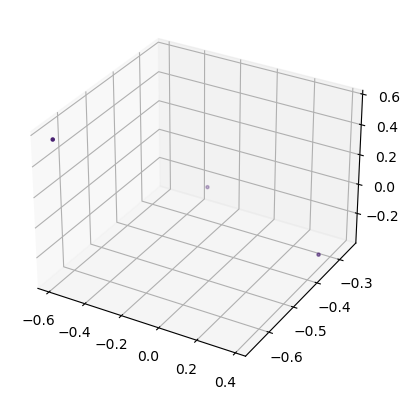

Test :: test acc: 1.000000, test avg acc: 1.000000


In [11]:
def _init_():
    if not os.path.exists('outputs'):
        os.makedirs('outputs')
    if not os.path.exists('outputs/'+args.exp_name):
        os.makedirs('outputs/'+args.exp_name)
    if not os.path.exists('outputs/'+args.exp_name+'/'+'models'):
        os.makedirs('outputs/'+args.exp_name+'/'+'models')

def train(args, io):
    train_loader = DataLoader(ModelNet40(partition='train', num_points=args.num_points), num_workers=2,
                              batch_size=args.batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(ModelNet40(partition='test', num_points=args.num_points), num_workers=2,
                             batch_size=args.test_batch_size, shuffle=True, drop_last=False)

    device = torch.device("cuda" if args.cuda else "cpu")

    #Try to load models
    if args.model == 'pointnet':
        model = PointNet(args).to(device)
    elif args.model == 'dgcnn':
        model = DGCNN_cls(args).to(device)
    else:
        raise Exception("Not implemented")

    print(str(model))

    model = nn.DataParallel(model)
    print("Let's use", torch.cuda.device_count(), "GPUs!")

    if args.use_sgd:
        print("Use SGD")
        opt = optim.SGD(model.parameters(), lr=args.lr*100, momentum=args.momentum, weight_decay=1e-4)
    else:
        print("Use Adam")
        opt = optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-4)

    if args.scheduler == 'cos':
        scheduler = CosineAnnealingLR(opt, args.epochs, eta_min=1e-3)
    elif args.scheduler == 'step':
        scheduler = StepLR(opt, step_size=20, gamma=0.7)
    
    criterion = cal_loss

    best_test_acc = 0
    for epoch in range(args.epochs):
        ####################
        # Train
        ####################
        train_loss = 0.0
        count = 0.0
        model.train()
        train_pred = []
        train_true = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device).squeeze()
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            opt.zero_grad()
            logits = model(data)
            loss = criterion(logits, label)
            loss.backward()
            opt.step()
            preds = logits.max(dim=1)[1]
            count += batch_size
            train_loss += loss.item() * batch_size
            train_true.append(label.cpu().numpy())
            train_pred.append(preds.detach().cpu().numpy())
        if args.scheduler == 'cos':
            scheduler.step()
        elif args.scheduler == 'step':
            if opt.param_groups[0]['lr'] > 1e-5:
                scheduler.step()
            if opt.param_groups[0]['lr'] < 1e-5:
                for param_group in opt.param_groups:
                    param_group['lr'] = 1e-5

        train_true = np.concatenate(train_true)
        train_pred = np.concatenate(train_pred)
        outstr = 'Train %d, loss: %.6f, train acc: %.6f, train avg acc: %.6f' % (epoch,
                                                                                 train_loss*1.0/count,
                                                                                 metrics.accuracy_score(
                                                                                     train_true, train_pred),
                                                                                 metrics.balanced_accuracy_score(
                                                                                     train_true, train_pred))
        io.cprint(outstr)

        ####################
        # Test
        ####################
        test_loss = 0.0
        count = 0.0
        model.eval()
        test_pred = []
        test_true = []
        for data, label in test_loader:
            data, label = data.to(device), label.to(device).squeeze()
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            logits = model(data)
            loss = criterion(logits, label)
            preds = logits.max(dim=1)[1]
            count += batch_size
            test_loss += loss.item() * batch_size
            test_true.append(label.cpu().numpy())
            test_pred.append(preds.detach().cpu().numpy())
        test_true = np.concatenate(test_true)
        test_pred = np.concatenate(test_pred)
        test_acc = metrics.accuracy_score(test_true, test_pred)
        avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
        outstr = 'Test %d, loss: %.6f, test acc: %.6f, test avg acc: %.6f' % (epoch,
                                                                              test_loss*1.0/count,
                                                                              test_acc,
                                                                              avg_per_class_acc)
        io.cprint(outstr)
        if test_acc >= best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'outputs/%s/models/model.t7' % args.exp_name)


def test(args, io):
    test_loader = DataLoader(ModelNet40(partition='test', num_points=args.num_points),
                             batch_size=args.test_batch_size, shuffle=True, drop_last=False)

    device = torch.device("cuda" if args.cuda else "cpu")

    #Try to load models
    if args.model == 'pointnet':
        model = PointNet(args).to(device)
    elif args.model == 'dgcnn':
        model = DGCNN_cls(args).to(device)
    else:
        raise Exception("Not implemented")

    model = nn.DataParallel(model)
    model.load_state_dict(torch.load(args.model_path))
    model = model.eval()
    test_acc = 0.0
    count = 0.0
    test_true = []
    test_pred = []
    
#     for data, label in test_loader:

#         data, label = data.to(device), label.to(device).squeeze()
#         data = data.permute(0, 2, 1)
#         batch_size = data.size()[0]
#         logits = model(data)
#         preds = logits.max(dim=1)[1]
#         test_true.append(label.cpu().numpy())
#         test_pred.append(preds.detach().cpu().numpy())


    for i, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device).squeeze()
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]

        logits = model(data)
        preds = logits.max(dim=1)[1]

        with torch.no_grad():  # Disable gradient computation for storing predictions
            test_true.append(label.cpu().numpy())
            test_pred.append(preds.detach().cpu().numpy())

        if i == 0:  # Compute Grad-CAM for the first sample in the batch
            target_class = torch.argmax(logits, dim=1)[0]  # Choose the class with the highest logit
            one_hot = torch.zeros_like(logits)
            one_hot[0, target_class] = 1

            # Backward pass for the target class
            model.zero_grad()
            logits.backward(gradient=one_hot, retain_graph=True)

            # Compute Grad-CAM
            grad_cam = model.module.compute_grad_cam()  # Note the addition of .module when using DataParallel
            point_cloud = data[0, :3, :]  # Assuming input_data is the input point cloud tensor with shape (batch_size, num_dims, num_points)
            visualize_grad_cam(grad_cam.view(-1), point_cloud.T)

        break  # Stop after visualizing one sample

                
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    test_acc = metrics.accuracy_score(test_true, test_pred)
    avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
    outstr = 'Test :: test acc: %.6f, test avg acc: %.6f'%(test_acc, avg_per_class_acc)
    io.cprint(outstr)


if __name__ == "__main__":
    # Training settings
    parser = argparse.ArgumentParser(description='Point Cloud Recognition')
    parser.add_argument('--exp_name', type=str, default='DGCNN_GC', metavar='N',
                        help='Name of the experiment')
    parser.add_argument('--model', type=str, default='dgcnn', metavar='N',
                        choices=['pointnet', 'dgcnn'],
                        help='Model to use, [pointnet, dgcnn]')
    parser.add_argument('--dataset', type=str, default='modelnet40', metavar='N',
                        choices=['modelnet40'])
    parser.add_argument('--batch_size', type=int, default=32, metavar='batch_size',
                        help='Size of batch)')
    parser.add_argument('--test_batch_size', type=int, default=16, metavar='batch_size',
                        help='Size of batch)')
    parser.add_argument('--epochs', type=int, default=250, metavar='N',
                        help='number of episode to train ')
    parser.add_argument('--use_sgd', type=bool, default=True,
                        help='Use SGD')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.001, 0.1 if using sgd)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--scheduler', type=str, default='cos', metavar='N',
                        choices=['cos', 'step'],
                        help='Scheduler to use, [cos, step]')
    parser.add_argument('--no_cuda', type=bool, default=False,
                        help='enables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--eval', type=bool,  default=False,
                        help='evaluate the model')
    parser.add_argument('--num_points', type=int, default=1024,
                        help='num of points to use')
    parser.add_argument('--dropout', type=float, default=0.5,
                        help='initial dropout rate')
    parser.add_argument('--emb_dims', type=int, default=1024, metavar='N',
                        help='Dimension of embeddings')
    parser.add_argument('--k', type=int, default=20, metavar='N',
                        help='Num of nearest neighbors to use')
    parser.add_argument('--model_path', type=str, default='/kaggle/input/model-result/model.t7', metavar='N',
                        help='Pretrained model path')
    args = parser.parse_args(['--eval','True'])

    _init_()

    io = IOStream('outputs/' + args.exp_name + '/run.log')
    io.cprint(str(args))

    args.cuda = not args.no_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    if args.cuda:
        io.cprint(
            'Using GPU : ' + str(torch.cuda.current_device()) + ' from ' + str(torch.cuda.device_count()) + ' devices')
        torch.cuda.manual_seed(args.seed)
    else:
        io.cprint('Using CPU')

    if not args.eval:
        train(args, io)
    else:
        test(args, io)

In [12]:
!nvidia-smi

Fri Mar 31 06:09:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    36W / 250W |   5161MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------